# 使用块的网络

## 1、VGG块
经典卷积神经网络的基本组成部分是下面的这个序列： 1. 带填充以保持分辨率的卷积层； 2. 非线性激活函数，如ReLU； 3. 池化层，如最大池化层。

VGG 论文：作者使用了带有  3×3  卷积核、填充为 1（保持高度和宽度）的卷积层，和带有  2×2  池化窗口、步幅为 2（每个块后的分辨率减半）的最大池化层。

定义了一个名为 vgg_block 的函数来实现一个 VGG 块。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import sys
sys.path.append('../../CommonFunctions/tools/')
import common_tools

In [5]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

## 2、VGG网络
与 AlexNet、LeNet 一样，VGG 网络可以分为两部分：第一部分主要由卷积层和池化层组成，第二部分由全连接层组成。
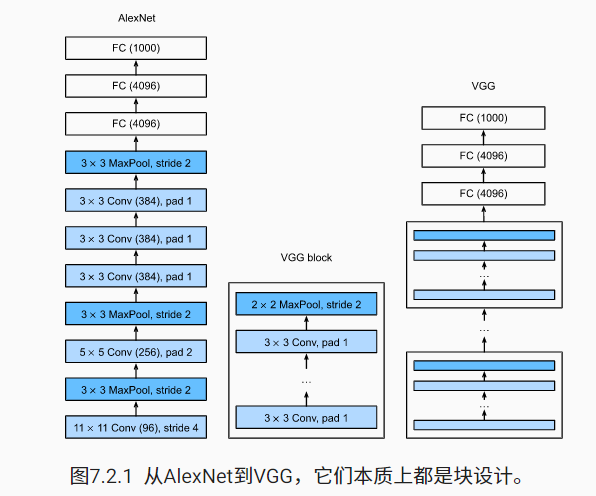
原始 VGG 网络有 5 个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 第一个模块有 64 个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到 512。由于该网络使用 8 个卷积层和 3 个全连接层，因此它通常被称为 VGG-11

In [6]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [7]:
def vgg(conv_arch):
    con_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        con_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(*con_blks, 
                         nn.Flatten(), 
                         #全连接部分 
                         nn.Linear(out_channels * 7 * 7, 4096), 
                         nn.ReLU(), 
                         nn.Dropout(0.5), 
                         nn.Linear(4096, 4096), 
                         nn.ReLU(), 
                         nn.Dropout(0.5), 
                         nn.Linear(4096, 10))
net = vgg(conv_arch)

In [8]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [9]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


## 3、训练模型
由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。

In [10]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

In [11]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 16, 112, 112])
Sequential output shape:	 torch.Size([1, 32, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 28, 28])
Sequential output shape:	 torch.Size([1, 128, 14, 14])
Sequential output shape:	 torch.Size([1, 128, 7, 7])
Flatten output shape:	 torch.Size([1, 6272])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


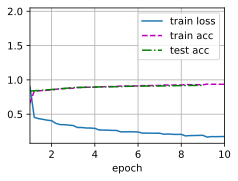

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = common_tools.load_data_fashion_mnist(batch_size, resize=224)
common_tools.train_ch6(net, train_iter, test_iter, num_epochs, lr, common_tools.try_gpu(1))